# User-defined geotherm and P,T dependent densities

Romain Beucher
The Australian National University
romain.beucher@anu.edu.au

Antonio Shettino


The notebook demonstrate how it is possible to initialise the temperature field using a user-defined function.
The material density are pressure and temperature dependent.

In [1]:
from underworld import UWGeodynamics as GEO
from underworld import visualisation as vis
from underworld import function as fn

loaded rc file /home/jovyan/workspace/codes/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry
print(GEO.__version__)

2.11.0-dev-ffeaab8(development)


We defined a series of values describing the system

In [3]:
H = 670e3 * u.meter # Height of the model
L = 4 * H           # Width of the model
Hp = 50e3*u.meter  
Hc = 35e3 * u.meter
H_LAB = 100e3 * u.meter
T0 = 293.15 * u.degK
P0 = 0.1 * u.megapascal
T_LAB = 1573.15 * u.degK
Tz = 1900.0 * u.degK
Fg = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2
diffusivity = 7.5e-7 * u.metre**2 / u.second
alpha = 3.5e-5 / u.kelvin
g = 9.81 * u.meter / u.second**2
rho_ref = 3370. * u.kilogram / u.metre**3
rho_c = 3300. * u.kilogram / u.metre**3
V_ff = 1.5 * u.centimeter/u.year

## Scaling

In [4]:
S_L = H
S_T = Tz
S_t = S_L/V_ff
S_rho = rho_ref
S_M = Fg * S_L**2 * S_t**2
S_t_Myr = S_t / (1e6 * 365 * 24 * 60 * 60)


GEO.scaling_coefficients["[length]"] = S_L
GEO.scaling_coefficients["[time]"] = S_t
GEO.scaling_coefficients["[temperature]"] = S_T
GEO.scaling_coefficients["[mass]"] = S_M

# Define Model Geometry

The domain is rectangular and goes down to 670 km. The width of the model is set to be 4 times its height.

In [5]:
Model = GEO.Model(elementRes=(256, 64), minCoord=(0.0*u.meter, -H),
                  maxCoord=(L,0), gravity=(0.0,-g))

## Define Materials

We define 2 mechanical materials: a 35km thick crust and an upper mantle.

In [6]:
Crust = Model.add_material(name="Crust", 
                           shape=GEO.shapes.Layer2D(top=Model.top,
                                                    bottom=-Hc))
Upper_Mantle = Model.add_material(name="Upper_Mantle", 
                                  shape=GEO.shapes.Layer2D(top=Crust.bottom,
                                                           bottom=Model.bottom))


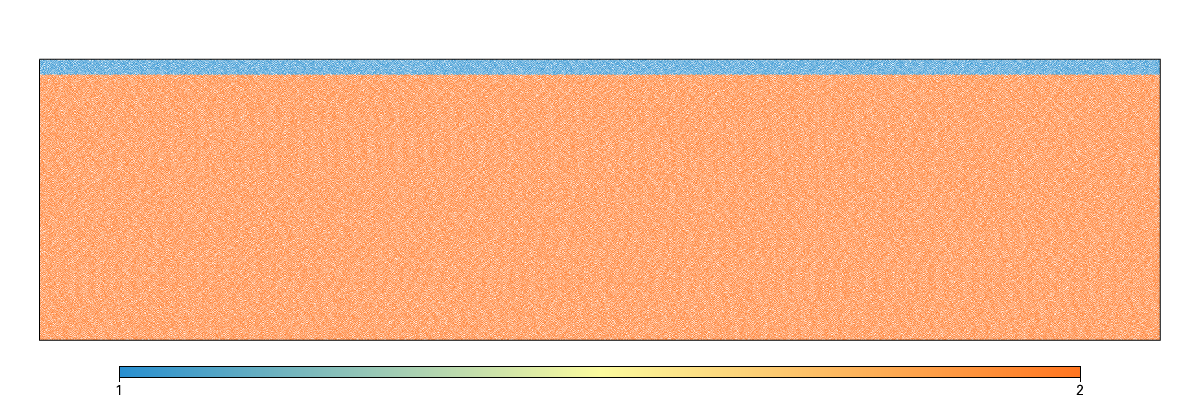

In [7]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.materialField)
Fig.show()

The densities of the materials are pressure and temperature dependent such as:

$$\rho = \rho_0 (1 + \beta \Delta P - \alpha \Delta T)$$

In [8]:
Crust.density = GEO.LinearDensity(2620. * u.kilogram / u.metre**3, 
                                  thermalExpansivity=alpha, 
                                  beta=1.0e-11/u.pascal)
Upper_Mantle.density = GEO.LinearDensity(rho_ref, 
                                         thermalExpansivity=alpha, 
                                         beta=1.0e-11/u.pascal)

In [9]:
rh = GEO.ViscousCreepRegistry()

Model.minViscosity = 1e18 * u.pascal * u.second
Model.maxViscosity = 1e26 * u.pascal * u.second
Crust.viscosity = rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995
Upper_Mantle.viscosity = rh.Dry_Olivine_Dislocation_Karato_and_Wu_1993

## Thermal properties

In [10]:
Model.diffusivity = diffusivity
Model.capacity = 1000. * u.joule/(u.kelvin*u.kilogram)

Crust.radiogenicHeatProd = 0.7 * u.microwatt/u.meter**3

## Set Temperature Field

We want to apply an initial temperature field such as:

   - The geotherm in the crust follows a simple 1D conduction profile with heat production.
   
   $$T = T_0 + \frac{q_0}{k}y - \frac{\rho H}{2k}y^2$$
   
     with $q_0$ the surface heatflow, $k$ the conductivity, $T_0$ the temperature at the surface and $H$ the radiogenic heat production per volume unit.
   
   - The temperature increases linearly from the base of the crust (968K) to the base of the lithosphere (1573.15K).
   - The temperature increases linearly from the base of the lithosphere (1573.15K) to the base of the model (1900K) 
   
   
We calculate the conductivity and set the surface heatflow:

In [11]:
k = Model.diffusivity * Model.capacity * rho_c
q0 = 6e-2 * u.watt / u.meter**2

Let's calculate the temperature at the base of the crust:

In [12]:
Tc = T0 + q0 * Hc / k - Crust.radiogenicHeatProd * Hc**2 / (2.0*k)

In [13]:
Tc

968.4025252525253 <Unit('kelvin')>

We set the gradient within the lithosphere and the mantle.

In [14]:
m1 = (T_LAB - Tc) / (H_LAB - Hc)
m2 = (Tz - T_LAB) / (H - H_LAB)

Here we choose to define 3 underworld functions to define the temperature profile:

In [15]:
crust_geotherm        = GEO.nd(T0) + GEO.nd(q0) * -Model.y / GEO.nd(k) - GEO.nd(Crust.radiogenicHeatProd) * GEO.nd(-Model.y)**2 / (2.0 * GEO.nd(k))
lithosphere_geotherm  = GEO.nd(m1) * (-Model.y - GEO.nd(Hc)) + GEO.nd(Tc)
mantle_geotherm       = GEO.nd(m2) * (-Model.y - GEO.nd(H_LAB)) + GEO.nd(T_LAB)

In [16]:
geotherm_fn = fn.branching.conditional([(-Model.y >= GEO.nd(H_LAB), mantle_geotherm),
                                        (-Model.y >= GEO.nd(Hc), lithosphere_geotherm),
                                        (True, crust_geotherm)])

# Initialise Model

To initalise the model temperature we use the `geotherm_fn`. 

UWGeodynamics will only solve for a steady-state temperature field if `temperature='steady-state'` and the requiste defintions for diffusivity variable(s) and thermal boundary conditions exist.

Here the pressure field will be automatically calculated with the default argument `pressure='lithostatic'`. If desired one could use an underworld function to override the pressure field definition, i.e. `pressure=myPress_fn`.

In [17]:
Model.init_model(temperature=geotherm_fn)


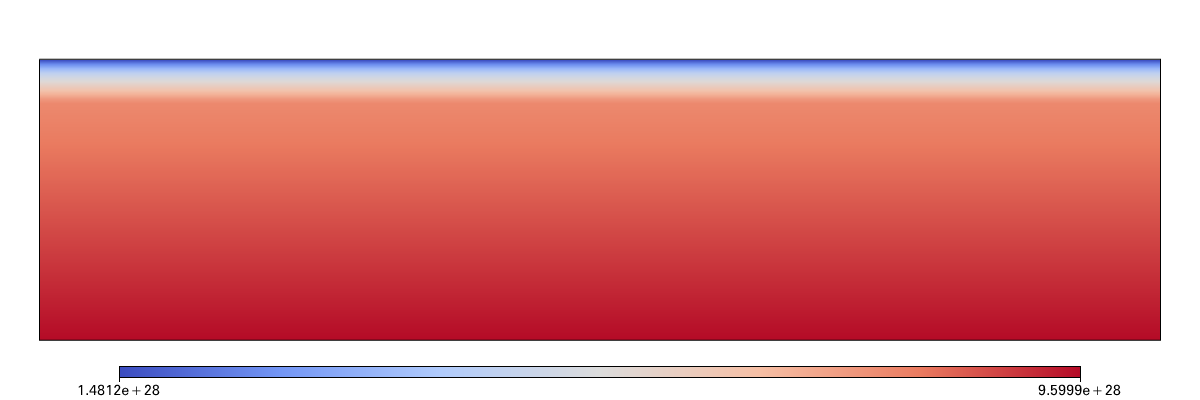

In [18]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.temperature, u.kg / u.m**3),colours="coolwarm")
Fig.show()

### Visualisation of the 1D profile at x=180km

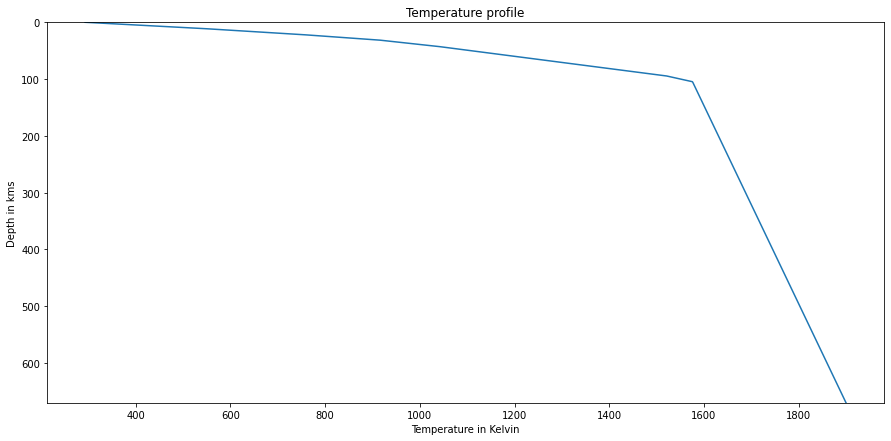

In [19]:
if GEO.nProcs == 1:

    import matplotlib.pyplot as plt

    distances, temperature = GEO.extract_profile(Model.temperature, line = [(180.* u.kilometer, 0.), (180.* u.kilometer, Model.bottom)])
    distances, pressure = GEO.extract_profile(Model.pressureField, line = [(180.* u.kilometer, 0.), (180.* u.kilometer, Model.bottom)])

    Fig, ax1 = plt.subplots(1,1,figsize=(15,7))
    ax1.plot(GEO.dimensionalise(temperature, u.degK).m, GEO.dimensionalise(distances, u.kilometer).m)
    ax1.set_xlabel("Temperature in Kelvin")
    ax1.set_ylabel("Depth in kms")
    ax1.set_ylim(670, 0)
    ax1.set_title("Temperature profile")

Finally check the density profile.


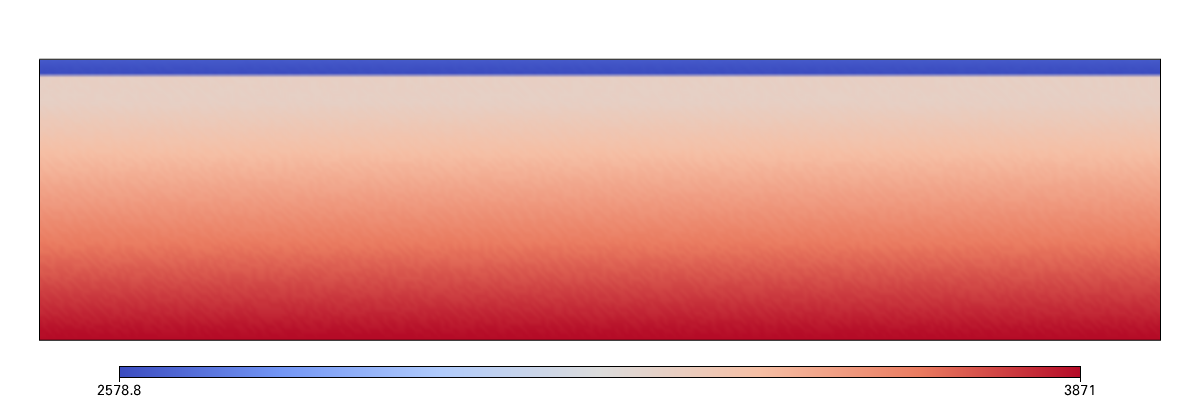

In [20]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.densityField, u.kg / u.m**3), colours="coolwarm")
Fig.show()